In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 22 days
/Users/anders/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Read in gold data and submissions

In [2]:
def read_dimsum_data(filename):
    results = pd.read_csv(filename, sep="\t", names=['token_offset', 'form', 'lemma', 'pos', 'mwe', 
                                    'parent_offset', 'strength', 'supersense', 'sent_id'],
                      quoting=3, na_filter=False)
    results.supersense = results.supersense.str.replace('^$', 'O')

    return results

gold = read_dimsum_data("dimsum16.test")
tweet_mask = gold.sent_id.str.startswith("twe")
ted_mask = gold.sent_id.str.startswith("ted")
trustpilot_mask = gold.sent_id.str.startswith("trustpilot")

supersense_labels = sorted(set(gold.supersense.unique()) - {'O'})
mwe_labels = sorted({'I', 'i'})

submission_ids = "106 108 211 214 227 248 249 254 255".split(" ")
submissions = {"S" + submission_id: read_dimsum_data(submission_id + ".test.pred")
               for submission_id in submission_ids}

Masks for relevant predictions with respect to gold data

In [3]:
has_supersense = gold.supersense.isin(supersense_labels)
has_mwe = gold.mwe.isin(mwe_labels)

## Pairwise comparisons between systems

In [4]:
def pairwise_comparison(gold_labels, system_labels_dict, compare='overlap'):
    system_ids = sorted(system_labels_dict.keys())
    pairwise = pd.DataFrame(0, index=system_ids, columns=system_ids, dtype=np.int)

    for i, sys_id_i in enumerate(system_ids):
        for j, sys_id_j in enumerate(system_ids):
            if i == j:
                continue

            sys_i_correct = gold_labels == system_labels_dict[sys_id_i]
            sys_j_correct = gold_labels == system_labels_dict[sys_id_j]
            
            val = None
            if compare == 'overlap':
                val = (sys_i_correct & sys_j_correct).sum()
            elif compare == 'oracle':
                val = (sys_i_correct | sys_j_correct).sum()
            elif compare == 'only_correct_in_first':
                val = (sys_i_correct & ~sys_j_correct).sum()
            elif compare == 'advantage':
                i_over_j = (sys_i_correct & ~sys_j_correct).sum()
                j_over_i = (sys_j_correct & ~sys_i_correct).sum()
                val = i_over_j - j_over_i
                
            pairwise.iloc[i, j] = val
                

    return pairwise

## Signficance testing

In [5]:
from scipy.stats import chi2
from itertools import product

def mcnemar_pval(sys_a_val, sys_b_val):
    if sys_a_val == sys_b_val:
        return 1.0
    test_stat = ((sys_a_val - sys_b_val)**2) / (sys_a_val + sys_b_val)
    pval = 1.0 - chi2.cdf(df=1, x=test_stat)
    return pval


In [6]:
gold_labels = np.concatenate([gold[has_supersense].supersense, gold[has_mwe].mwe])
system_labels_dict = {sys_id: np.concatenate([sys[has_supersense].supersense, sys[has_mwe].mwe])
                      for sys_id, sys in submissions.items()}
mcnemar_pairwise = pairwise_comparison(gold_labels, system_labels_dict, 'only_correct_in_first')

system_ids = list(mcnemar_pairwise.index)
pvals = pd.DataFrame(0, index=system_ids, columns=system_ids)

for sys_a_id, sys_b_id in product(system_ids, system_ids):
    pvals.ix[sys_a_id, sys_b_id] = mcnemar_pval(mcnemar_pairwise.ix[sys_a_id, sys_b_id], 
                                                mcnemar_pairwise.ix[sys_b_id, sys_a_id]);

### All-pairs significance matrix

In [7]:
(pvals < 0.05) * 1

,S106,S108,S211,S214,S227,S248,S249,S254,S255
S106,0,1,1,1,1,1,1,1,1
S108,1,0,1,1,1,1,1,1,1
S211,1,1,0,1,1,1,1,0,1
S214,1,1,1,0,1,1,0,1,1
S227,1,1,1,1,0,1,1,1,1
S248,1,1,1,1,1,0,1,1,1
S249,1,1,1,0,1,1,0,1,1
S254,1,1,0,1,1,1,1,0,1
S255,1,1,1,1,1,1,1,1,0


## Differences between systems

/Users/anders/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


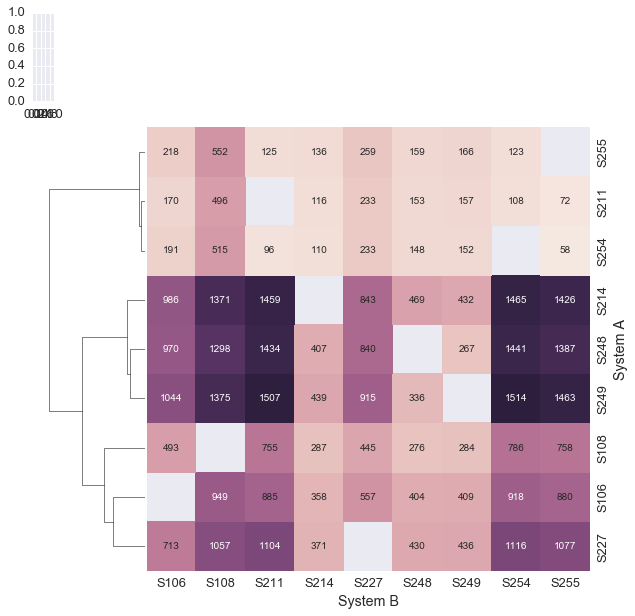

In [8]:
sns.set_context("paper")
sns.set(font_scale=1.29)
mcnemar_pairwise.index.name = "System A"
mcnemar_pairwise.columns.name = "System B"
grid = sns.matrix.clustermap(mcnemar_pairwise, annot=True, fmt="d", 
                      mask=np.eye(len(mcnemar_pairwise)), col_cluster=False, cbar=False)
grid.savefig("system_pairwise_clusters.pdf")

## Easy vs difficult

In [9]:
correct_per_instance = pd.DataFrame()

for submission_id, sub in submissions.items():
    correct_per_instance[submission_id] = sub.supersense == gold.supersense
    
correct_per_instance = correct_per_instance.sum(axis=1)

Supersense plot

/Users/anders/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


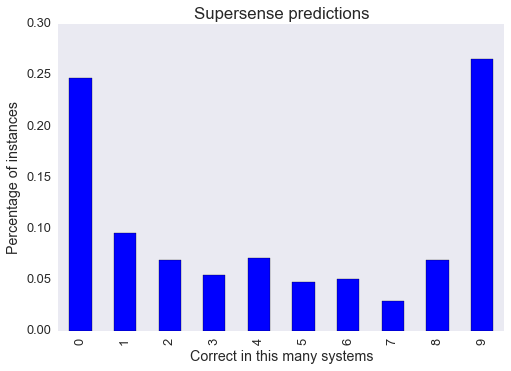

In [10]:
fig, ax = plt.subplots()
sns.set_context("paper")
sns.set(font_scale=1.4)
sns.set_style("white")


correct_counts = correct_per_instance[has_supersense].value_counts().sort_index()


(correct_counts / correct_counts.sum()).plot(kind='bar', ax=ax)
ax.set_ylabel("Percentage of instances")
ax.set_xlabel("Correct in this many systems")
ax.set_title("Supersense predictions")
sns.despine(ax=ax)
ax
fig.savefig("supersense_predictions.pdf")

Stacked version of the diagram above

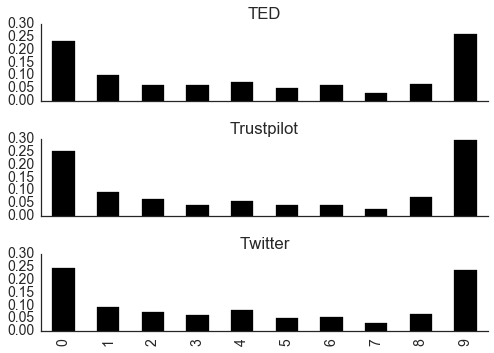

In [11]:
fig = plt.figure()
sns.set_style("white")
by_domain = pd.DataFrame({
        'Twitter': correct_per_instance[has_supersense & tweet_mask].value_counts(),
        'TED': correct_per_instance[has_supersense & ted_mask].value_counts(),
        'Trustpilot': correct_per_instance[has_supersense & trustpilot_mask].value_counts(),
    })


by_domain_pct = by_domain / by_domain.sum()

axes = by_domain_pct.plot(kind='bar', subplots=True, sharey=True, color='black', legend=False)

sns.despine()

plt.subplots_adjust(hspace=0.5)



#sns.set_context("paper")


#.value_counts().sort_index().plot(kind='bar')



## Proportions plot

/Users/anders/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


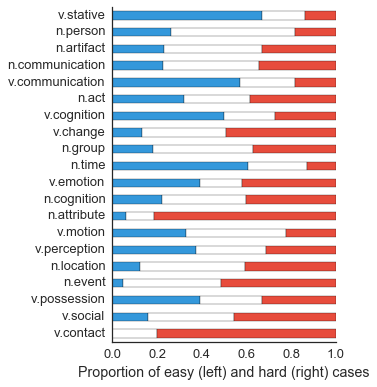

In [12]:
from matplotlib.colors import ListedColormap

#sns.set_context("paper")
sns.set(font_scale=1.3)
sns.set_style("white")

best_mask = correct_per_instance[has_supersense] >= 8
worst_mask = correct_per_instance[has_supersense] <= 1
rest_mask = ~(best_mask | worst_mask)

super_difficulty = pd.DataFrame({'best': gold[has_supersense][best_mask].supersense.value_counts(), 
              'worst': gold[has_supersense][worst_mask].supersense.value_counts(),
              'rest': gold[has_supersense][rest_mask].supersense.value_counts(),
              'total': gold[has_supersense].supersense.value_counts()
             })
super_difficulty.fillna(0, inplace=True)
super_difficulty.sort_values('total', ascending=False, inplace=True)

# Get the most common noun and verb supersenses
verb_mask = super_difficulty.index.str.startswith("v.")
noun_mask = super_difficulty.index.str.startswith("n.")

selection = super_difficulty[noun_mask].head(10).index | super_difficulty[verb_mask].head(10).index
super_difficulty = super_difficulty.ix[selection].sort_values('total', ascending=True)

total = super_difficulty.total
del super_difficulty['total']
sd_proportions = (super_difficulty.T / total).T

cmap = ListedColormap(["#3498db", 'white', "#e74c3c"])
fig, ax = plt.subplots(figsize=(4, 6))
sd_proportions[['best', 'rest', 'worst']].plot(kind='barh', stacked=True, ax=ax, 
                                                        legend=False, colormap=cmap)

#ax.set_ylabel("Superlabels")
ax.set_xlabel("Proportion of easy (left) and hard (right) cases")
sns.despine(ax=ax)
ax
fig.savefig("proportion_of_easy_and_hard_supersenses.pdf", bbox_inches='tight')

### Lemma to supersense entropy

In [13]:
from scipy.stats import entropy
def avg_supersense_ambiguity(lemmas):
    entropies = []
    for lemma in lemmas:
        dist = gold[gold.lemma == lemma].supersense.value_counts()
        entropies.append(entropy(dist , base=2))
    print(entropies)
    
    return np.mean(entropies)

avg_supersense_ambiguity(['be'])

[0.91796549918326209]


0.91796549918326209

In [14]:
ss_cumsum = gold[gold.supersense == 'v.contact'].lemma.value_counts().cumsum()
ss_cumsum /= ss_cumsum.iloc[-1]
print(ss_cumsum.iloc[10])
print(ss_cumsum.index[:10])
#avg_supersense_ambiguity(ss_cumsum.index[:50])

0.442857142857
Index(['deliver', 'post', 'receive', 'take', 'put', 'hit', 'pick', 'cut',
       'fit', 'have'],
      dtype='object')
